In [5]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sn
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def tsne(vecs, labels, title="", ind2label = None, words = None, metric = "l2"):

  tsne = TSNE(n_components=2)#, angle = 0.5, perplexity = 20)
  vecs_2d = tsne.fit_transform(vecs)
  label_names = sorted(list(set(labels.tolist())))
  num_labels = len(label_names)

  names = sorted(set(labels.tolist()))

  plt.figure(figsize=(6, 5))
  colors = "red", "blue", "green", "orange", "purple"
  for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
     plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label if ind2label is None else ind2label[label], alpha = 0.3, marker = "s" if i==0 else "o")
     plt.legend(loc = "upper right")

  plt.title(title)
  #plt.savefig("../results/plots/{}.png".format(title), dpi=600)
  plt.show()

In [20]:
fname = "../data/datasets.5000a.layer=6-random0.masked=True.pickle"
fname2 = "../data/datasets.5000t.layer=6-random0.masked=True.pickle"

with open(fname, "rb") as f:
    data = pickle.load(f)

    
with open(fname2, "rb") as f:
    data_nonlex = pickle.load(f)

In [21]:
projs_path = "../data/type2P.layer=6-random0.iters=16.classifier=sgd.masked=True.pickle"
with open(projs_path, "rb") as f:
    type2proj = pickle.load(f)
    
comps = projs_path.split(".")
layer = comps[-5]
iters = comps[-4]
print(layer, iters)

layer=6-random0 iters=16


In [22]:
vecs, vecs_rowspace, labels = [],[], []
vecs_rowspace_nonlex = []
k = 300
type2vecs_rowspace = {}
type2vecs_rowspace_nonlex = {}

for type_pos in data.keys():
    
    P_rowspace = np.eye(768) - type2proj[type_pos]
    #P_rowspace = np.eye(768) - type2proj["prrc"]
    
    train_x, train_y = data[type_pos]["train"]
    train_x_nonlex, train_y_nonlex = data_nonlex[type_pos]["train"]
    
    mask = train_y != 0
    mask_nonlex = train_y_nonlex != 0
    
    relevant_x = train_x[mask]
    relevant_x_nonlex = train_x_nonlex[mask_nonlex]
    
    label = [type_pos] * k
    vecs.append(relevant_x[:k])
    vecs_rowspace.append((relevant_x.dot(P_rowspace))[:k])
    vecs_rowspace_nonlex.append(relevant_x_nonlex.dot(P_rowspace)[:k])
    
    type2vecs_rowspace[type_pos] = relevant_x.dot(P_rowspace)
    type2vecs_rowspace_nonlex[type_pos] = relevant_x_nonlex.dot(P_rowspace)
    
    labels.extend(label)
vecs = np.concatenate(vecs, axis = 0)
vecs_rowspace = np.concatenate(vecs_rowspace, axis = 0)
vecs_rowspace_nonlex = np.concatenate(vecs_rowspace_nonlex, axis = 0)
labels = np.array(labels)
print(vecs.shape, len(labels))

(1500, 768) 1500


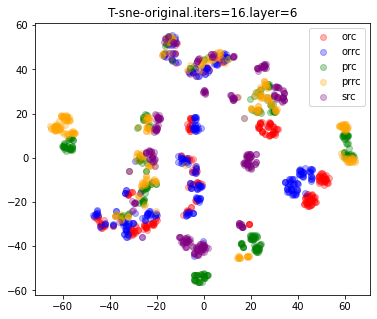

In [10]:
tsne(vecs, labels, "T-sne-original.{}.{}".format(iters, layer))

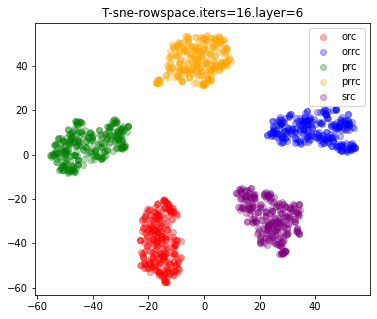

In [11]:
tsne(vecs_rowspace, labels, title = "T-sne-rowspace.{}.{}".format(iters, layer))

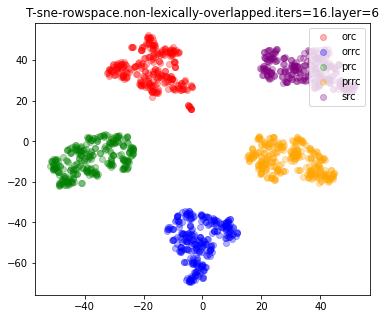

In [12]:
tsne(vecs_rowspace_nonlex, labels, title = "T-sne-rowspace.non-lexically-overlapped.{}.{}".format(iters, layer))

In [23]:
sims = np.zeros((5,5))
type2ind = {d:i for i,d in enumerate(type2vecs_rowspace.keys())}
ind2type = {i:d for d,i in type2ind.items()}

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

for key, vecs in type2vecs_rowspace.items():
    for key2, vecs2 in type2vecs_rowspace_nonlex.items():
        #mean1, mean2 = np.mean(vecs, axis = 0), np.mean(vecs2, axis = 0)
        #mean1_normed, mean2_normed = mean1 / np.linalg.norm(mean1), mean2 / np.linalg.norm(mean2)
        
        sims2 = cosine_similarity(vecs, vecs2)
        print(sims2.shape)
        vecs_normed = vecs / np.linalg.norm(vecs, axis = 1, keepdims = True)
        vecs2_normed = vecs2 / np.linalg.norm(vecs2, axis = 1, keepdims = True)
        
        sims[type2ind[key], type2ind[key2]] = np.mean(sims2) #mean1_normed.dot(mean2_normed.T)

(6206, 6402)
(6206, 6305)
(6206, 5116)
(6206, 8721)
(6206, 6305)
(6195, 6402)
(6195, 6305)
(6195, 5116)
(6195, 8721)
(6195, 6305)
(5014, 6402)
(5014, 6305)
(5014, 5116)
(5014, 8721)
(5014, 6305)
(8602, 6402)
(8602, 6305)
(8602, 5116)
(8602, 8721)
(8602, 6305)
(6195, 6402)
(6195, 6305)
(6195, 5116)
(6195, 8721)
(6195, 6305)


In [25]:
type2ind

{'src': 0, 'orc': 1, 'orrc': 2, 'prc': 3, 'prrc': 4}

In [26]:
print(type2vecs_rowspace["src"].dot(type2vecs_rowspace_nonlex["src"].T).mean())
print(type2vecs_rowspace["src"].dot(type2vecs_rowspace_nonlex["orc"].T).mean())

15.832499738027158
13.636133550045837


In [27]:
labels = [ind2type[i] for i in range(len(ind2type))]


In [28]:
def plot(labels, results, layer, classifier,iters):

    df_cm = pd.DataFrame(results, index = labels,
                  columns = labels)
    
    print(df_cm)
    
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.title("Cosine similarity in RC subspace between various RCs. {}. classifier: {}. {}".format(layer, classifier, iters))
    plt.show()
    plt.savefig("../results/plots/original-similarity.pairs:{}.classifier:{}.{}.png".format(layer, classifier, iters), dpi=300)    


           src       orc      orrc       prc      prrc
src   0.903508  0.631796  0.457608  0.529013  0.458078
orc   0.621674  0.914629  0.588889  0.547467  0.439005
orrc  0.467937  0.639733  0.866662  0.432919  0.387688
prc   0.574062  0.587579  0.430284  0.868341  0.625675
prrc  0.478993  0.451164  0.371364  0.599985  0.831661


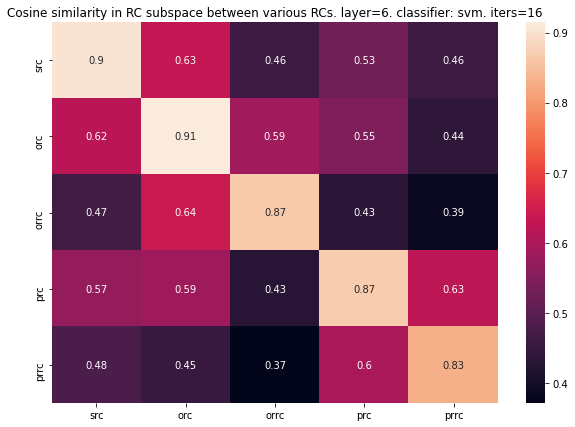

<Figure size 432x288 with 0 Axes>

In [19]:
plot(labels, sims, layer, "svm", iters)

           src       orc      orrc       prc      prrc
src   0.707114  0.481120  0.441789  0.376760  0.338928
orc   0.450661  0.783859  0.378091  0.457859  0.304268
orrc  0.434231  0.403506  0.850626  0.378564  0.416311
prc   0.374180  0.462933  0.368261  0.795444  0.274866
prrc  0.317316  0.304747  0.414319  0.264980  0.679599


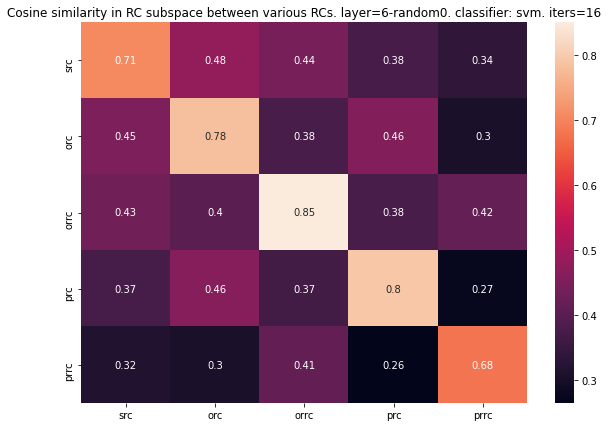

<Figure size 432x288 with 0 Axes>

In [29]:
plot(labels, sims, layer, "svm", iters)